### Statistical Inference: Permutation test

This notebook demostrate how to perform permutation test for hypothesis testing and p-value calculation.

1. Correlation coefficient
2. Moran's I

### Correlation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import *

url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'

df = pd.read_csv(url)
df = df.dropna()

#### Lets draw a very small sample with only 10 points. 

In [2]:
small_sample_car = df.sample(10,random_state=222)
small_sample_car

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
165,20.0,8,262.0,110.0,3221,13.5,75,usa,chevrolet monza 2+2
380,36.0,4,120.0,88.0,2160,14.5,82,japan,nissan stanza xe
16,18.0,6,199.0,97.0,2774,15.5,70,usa,amc hornet
261,18.1,6,258.0,120.0,3410,15.1,78,usa,amc concord d/l
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
99,18.0,6,232.0,100.0,2945,16.0,73,usa,amc hornet
206,26.5,4,140.0,72.0,2565,13.6,76,usa,ford pinto
86,14.0,8,304.0,150.0,3672,11.5,73,usa,amc matador
267,27.5,4,134.0,95.0,2560,14.2,78,japan,toyota corona
232,16.0,8,351.0,149.0,4335,14.5,77,usa,ford thunderbird


Text(0, 0.5, 'Acceleration')

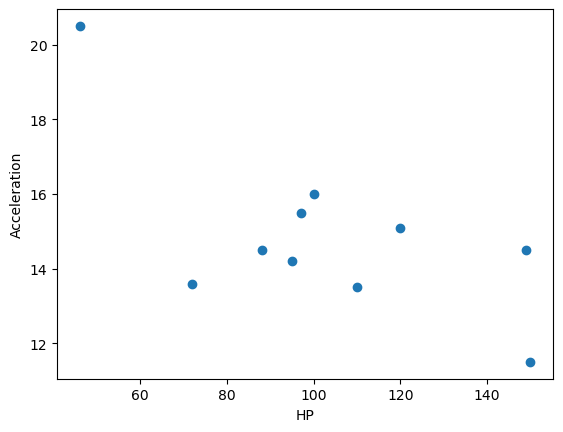

In [3]:
plt.scatter(small_sample_car.horsepower, small_sample_car.acceleration)
plt.xlabel("HP")
plt.ylabel("Acceleration")

#### Pearson correlation based on this small sample, note the analytical p-value here is ~0.03

In [4]:
pearson_rslt = pearsonr(small_sample_car.horsepower, small_sample_car.acceleration)

print("Pearson:",pearson_rslt)

Pearson: PearsonRResult(statistic=-0.6832264558183371, pvalue=0.02941732498278316)


In [5]:
np.random.permutation(small_sample_car.acceleration)

array([14.2, 14.5, 20.5, 15.5, 15.1, 13.6, 16. , 13.5, 14.5, 11.5])

#### Define a permutation test function for correlation:

In [6]:
def permutation_cor(sample_car):
    
    null_cor_list = []
    
    for i in range(10000):
        #permutate one variable, while hold the other constant.
        subsample_Y = np.random.permutation(sample_car.acceleration)
        
        #compute correlation
        sample_cor = pearsonr(sample_car.horsepower, subsample_Y)[0]

        null_cor_list.append(sample_cor)
    
    return null_cor_list
    

#### This gives us the correlation coefficient under the null hypothesis.

In [7]:
null_dist = permutation_cor(small_sample_car)

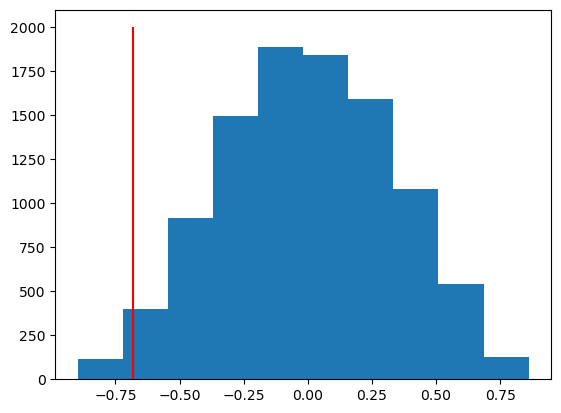

In [8]:
plt.hist(null_dist)

plt.vlines(pearson_rslt[0],ymin=0,ymax=2000,color="red")

#### Lets count how many times the correlation under unll would be greater (in magnitude) than the sample correlation.
#### This gives us a simulated p-value.

In [9]:
np.sum(np.abs(np.array(null_dist)) >= np.abs(pearson_rslt[0]))

303

In [10]:
import numpy as np
p_sim = np.sum(np.abs(np.array(null_dist)) >= np.abs(pearson_rslt[0]))/10000


In [11]:
print("The simulated p-value (2-tail): ", p_sim)

print("The actual p-value (2-tail) : ", pearson_rslt[1])

The simulated p-value (2-tail):  0.0303
The actual p-value (2-tail) :  0.02941732498278316


### Moran's I

Let's look at the spatial autocorrelation of ALAND in IL.

In [12]:
import geopandas as gpd

In [13]:
IL = gpd.read_file("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/IL_acs/IL_acs.shp")

In [14]:
IL.columns

Index(['state', 'county', 'NAME_x', 'total_pop', 'pct_65_ove', 'pct_black',
       'pct_hispan', 'males', 'females', 'pct_bach', 'GEOID_x', 'STATEFP',
       'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID_y', 'NAME_y', 'LSAD',
       'ALAND', 'AWATER', 'GEOID_int', 'geometry'],
      dtype='object')

<Axes: >

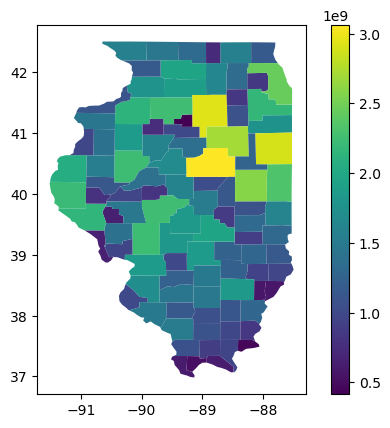

In [15]:
IL.plot(column="ALAND",legend=True)

#### Calculate the Moran's I values using the esda package.

In [16]:
from libpysal.weights.contiguity import Queen

value = IL['ALAND'].values #Get the data we are interested.

w = Queen.from_dataframe(IL) #Generate W matrix using Queen contiguity

w.transform = 'r' #Row-standardization of the weight matrix

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_67700/246861888.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(IL) #Generate W matrix using Queen contiguity


In [42]:
from esda.moran import Moran
from splot.esda import plot_moran

il_moran = Moran(value, w, permutations=9999, two_tailed=True)


print("Moran's I:", il_moran.I)

print("analytical p-value:",il_moran.p_norm)

print("Simulated p-value:",il_moran.p_sim)

Moran's I: 0.16857257061968103
analytical p-value: 0.0035814725750113125
Simulated p-value: 0.004


/Users/ziqili/anaconda3/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


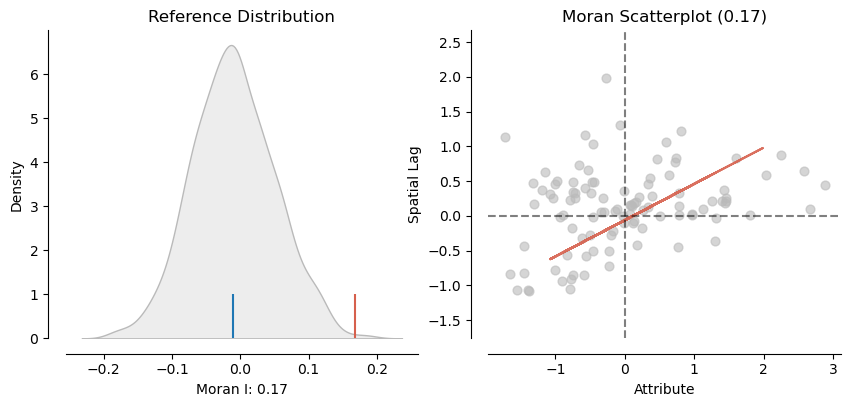

In [18]:
plot_moran(il_moran, zstandard=True, figsize=(10,4))
plt.show()

In [43]:
#Define a permutation test function for Moran's I:
def permutation_moran(geodataframe):
    
    w = Queen.from_dataframe(IL) 
    
    null_moran_list = []
    
    for i in range(10000):
        
        value = np.random.permutation(geodataframe['ALAND'].values) #Get the data we are interested.
        
        #compute moran's I
        moran = Moran(value, w)
        
        null_moran_list.append(moran.I)
    
    return null_moran_list
    

#### We randomly assign a value to each county, and calculate Moran's I for each map.

<Axes: >

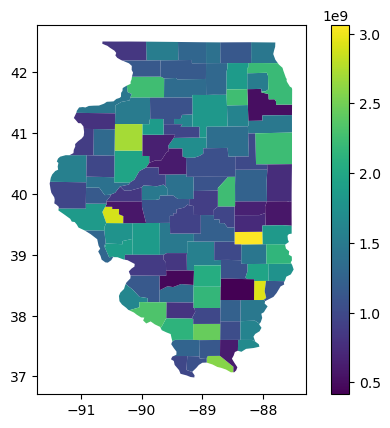

In [44]:
import numpy as np
IL.plot(column=np.random.permutation(IL['ALAND'].values),legend=True)

Moran's I under the null hypothesis

In [45]:
null_moran = permutation_moran(IL)

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_67700/1800511431.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(IL)


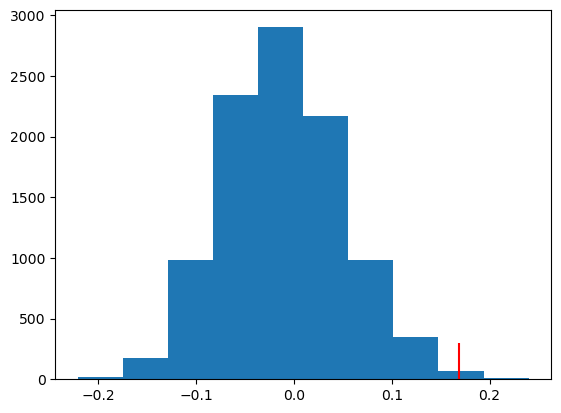

In [46]:
plt.hist(null_moran)
plt.vlines(il_moran.I,ymin=0,ymax=300,color="red")

In [47]:
p_sim = np.sum(np.abs(np.array(null_moran)) >= np.abs(il_moran.I))/10000


In [48]:
print("Analytical p-value:",il_moran.p_norm)
print("Simulated p-value from esda's permutation:",il_moran.p_sim)

print("Simulated p-value from permutation test:",p_sim)

Analytical p-value: 0.0035814725750113125
Simulated p-value from esda's permutation: 0.004
Simulated p-value from permutation test: 0.005
